In [122]:
import pandas as pd
import numpy as np
import talib as ta
import yfinance as yf
from datetime import date
from datetime import timedelta

Define some parameters and the function to get the stock price data as well as moving average

In [123]:
#Use 3 years data
delta = timedelta(days=365*3)
today = date.today()
preyears=today-delta

In [145]:
#Function to get dataframe of stock and moving average price
def getstock(stock,startday=str(preyears),endday=str(today)):
    df = yf.download(stock,start = startday ,end=endday)
    df_adj = df.reindex(columns=[ 'Open', 'High', 'Low','Close'])#.rename(columns={"Adj Close":"Close"})
    df_adj['SMA5'] = ta.SMA(df.Close,timeperiod = 5)
    df_adj['SMA20'] = ta.SMA(df.Close,timeperiod = 20)
    df_adj['SMA60'] = ta.SMA(df.Close,timeperiod = 60)
    df_adj['SMA120'] = ta.SMA(df.Close,timeperiod = 120)
    df_adj['SMA250'] = ta.SMA(df.Close,timeperiod = 250)
    return df_adj

In [146]:
#Choose NVDA to test the basic MA strategy
dftest = getstock("GOOG")#.loc["2023"]

[*********************100%***********************]  1 of 1 completed


In [147]:
#Show the dataframe table
dftest

,Open,High,Low,Close,SMA5,SMA20,SMA60,SMA120,SMA250
Date,,,,,,,,,
2020-10-26,81.250504,81.912003,78.824997,79.522499,NaN,NaN,NaN,NaN,NaN
2020-10-27,79.783501,80.342247,79.139000,80.212997,NaN,NaN,NaN,NaN,NaN
2020-10-28,77.987000,78.067497,75.731003,75.831001,NaN,NaN,NaN,NaN,NaN
2020-10-29,76.117996,79.685501,76.112000,78.362000,NaN,NaN,NaN,NaN,NaN
2020-10-30,83.605499,84.349998,80.223000,81.050499,78.995799,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-10-19,139.800003,141.005005,138.600006,138.979996,139.664001,136.389001,134.247001,127.384125,111.62034
2023-10-20,138.589996,139.039993,136.244995,136.740005,139.296002,136.663501,134.361501,127.626042,111.76138
2023-10-23,136.229996,139.020004,135.110001,137.899994,138.778000,136.950001,134.443001,127.892042,111.90110


Data Visualization: Draw five MA and the close price lines

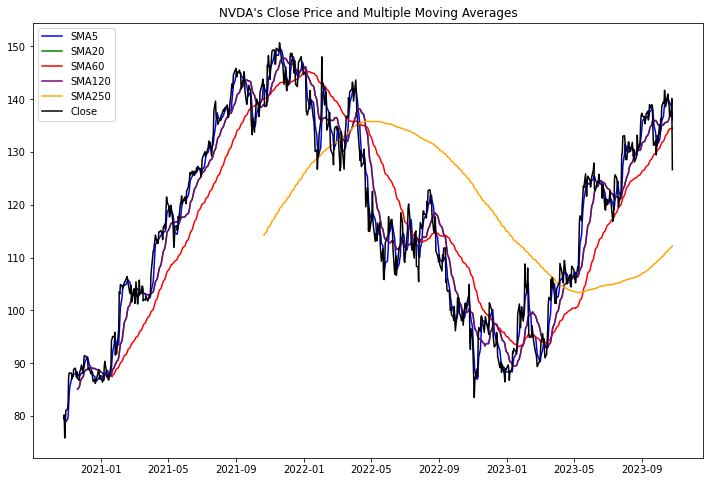

In [148]:

SMA5 = dftest.SMA5
SMA20 = dftest.SMA20
SMA60 = dftest.SMA60
SMA120 = dftest.SMA20
SMA250 = dftest.SMA250
Close = dftest.Close

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(SMA5, label='SMA5', color='blue')
plt.plot(SMA20, label='SMA20', color='green')
plt.plot(SMA60, label='SMA60', color='red')
plt.plot(SMA120, label='SMA120', color='purple')
plt.plot(SMA250, label='SMA250', color='orange')
plt.plot(Close, color='black', label='Close')
plt.title("NVDA's Close Price and Multiple Moving Averages")
plt.legend()
plt.show()


In [144]:
count_valid_SMA250 = dftest['SMA250'].notna().sum()
count_valid_SMA250

205

In [129]:
#Because calculating 250 MA price means the first 249 rows of price will be N/A, if we want to use 250 MA, we have to start from row 250 which is index 249
#Similar, if the stratey involves SMA60, we have to start from index 59 
len(dftest.Close) - count_valid_SMA250

249

Using 3 SMA (5, 20, 60) lines to build up MA strategy and record these signals

In [130]:
#Create signal array
sig = []

#Set up stock condition (0 means no stock on hands)
con1 = 0

for i in range(59):
    sig.append(0)

for i in range(59,len(dftest.Close)):
    if dftest.SMA5[i] > dftest.SMA20[i] and dftest.SMA20[i] > dftest.SMA60[i]:
        if con1 == 0:
            sig.append(1)
            con1 += 1
        else:
            sig.append(0)
    elif dftest.SMA5[i] < dftest.SMA20[i] and dftest.SMA20[i] < dftest.SMA60[i]:
        if con1 == 0:
            sig.append(0)
        else:
            sig.append(-1)
            con1 -=1
    else:
        sig.append(0)
        
        
sma_sig = pd.Series(index = dftest.index, data = sig)

In [131]:
sma_sig

Date
2020-10-26    0
2020-10-27    0
2020-10-28    0
2020-10-29    0
2020-10-30    0
             ..
2023-10-19    0
2023-10-20    0
2023-10-23    0
2023-10-24    0
2023-10-25    0
Length: 755, dtype: int64

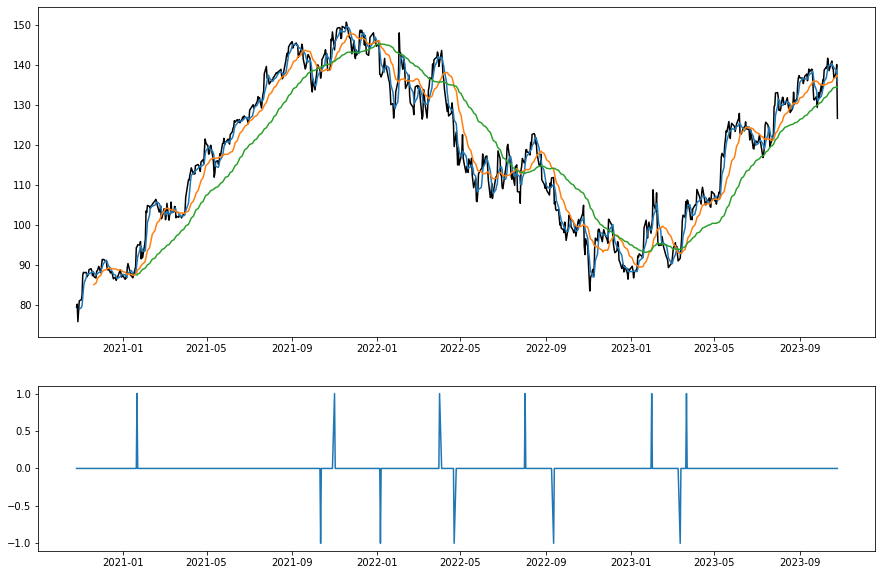

In [132]:
from matplotlib import gridspec

fig = plt.figure(figsize=(15,10))
# set height ratios for sublots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# the fisrt subplot
ax0 = plt.subplot(gs[0])

ax0.plot(Close,color="black")
ax0.plot(SMA5)
ax0.plot(SMA20)
ax0.plot(SMA60)


#the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
ema_sig = pd.Series(index = sma_sig.index, data = list(sma_sig.values))
ax1.plot(sma_sig)

In [133]:
def profit(df, sig, commission = 0.001425, tax = .003):

    #Set up stock buying price and selling price
    buyprice = 0
    sellprice = 0
    each_return = 0
    total_returns = 1

    #Check if the df's row number is equal to signal's length
    if len(df) == len(sig):

         #Go through each signal and trade stock; Because the strategy trade stock the next day after the signal appears, 
         #if the signal appear at the end of the array, there won't have corresponding close price to trade. 
         #So in order to prevent this situation, we have can go through n-1 signal
          for i in range(len(sig) - 1):
               #Buy stock at open price next day
               if sig[i] == 1:
               
                   buyprice = df.Open[i+1] * (1 + commission)
                   print("Buy stock at $", buyprice)

               elif sig[i] == -1:

                    sellprice = df.Open[i+1] * (1 - commission - tax)
                    print("Sell stock at $", sellprice)
                    each_return = (sellprice/buyprice) - 1 
                    print("This time the return rate is "+ str(round(each_return* 100,2)) + "%" )
                    total_returns *= (sellprice/buyprice)
               
               else:
                    pass

          print("Total Return: "+ str(round(total_returns* 100,2)) + "%")

         
    else:
         print("data frame length is not equal to signal's length")
    
    


In [134]:
profit(dftest,sma_sig)

Buy stock at $ 94.91906377716064
Sell stock at $ 137.14045625
This time the return rate is 44.48%
Buy stock at $ 145.0157558643341
Sell stock at $ 137.2947691596985
This time the return rate is -5.32%
Buy stock at $ 141.0251683113098
Sell stock at $ 118.90102124195099
This time the return rate is -15.69%
Buy stock at $ 116.50578083267212
Sell stock at $ 108.40816114234924
This time the return rate is -6.95%
Buy stock at $ 99.8821273607254
Sell stock at $ 92.65816494617462
This time the return rate is -7.23%
Buy stock at $ 106.04089263877869
Total Return: 99.55%


In [152]:
print("Buy and hold retun rate is : "+ str(round((dftest.Close[-1]/dftest.Open[0] - 1)* 100, 2)) + "%")

Buy and hold retun rate is : 55.9%


Summary:

MA strategy are effective in identifying trends in asset prices, helping traders and investors make informed decisions.It's a relatively simple and easy-to-understand strategy. But Moving avearges are lagging indicators, meaning they are based on historical data. They may not always provid timely signals.
Also, it is not suitable for all assets: The moving average strategy may not be effective for all types of assets or in all market conditions. It works best in trending markets.

In the case of the Google, The total return is 99%, which is more than buy and hold return, 56%. 

In conclusion, the moving average strategy is a valuable tool for traders and investors, but it should be used in conjunction with other analysis methods and tailored to specific market conditions and objectives. 
